<a href="https://colab.research.google.com/github/roscibely/Gender-Classification/blob/main/Gender_Classification_with_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Gender Classification Using Deep Learning


Link to our paper: https://www.overleaf.com/read/wycykmrpfhtw

## 1.1 Necessary libraries

In [2]:
import pandas as pd                       # structures and data analysis
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

## 1.2 Download the dataset

In [3]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100787 entries, 0 to 100786
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   alternative_names  70745 non-null   object 
 1   classification     100787 non-null  object 
 2   first_name         100787 non-null  object 
 3   frequency_female   60484 non-null   float64
 4   frequency_male     50932 non-null   float64
 5   frequency_total    100787 non-null  int64  
 6   frequency_group    100787 non-null  int64  
 7   group_name         100787 non-null  object 
 8   ratio              100787 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


In [5]:
df.describe()

,frequency_female,frequency_male,frequency_total,frequency_group,ratio
count,6.048400e+04,5.093200e+04,1.007870e+05,1.007870e+05,100787.000000
mean,1.529848e+03,1.740660e+03,1.797718e+03,1.766752e+04,0.981382
std,5.116376e+04,3.856265e+04,4.837138e+04,1.783261e+05,0.076555
min,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,0.500000
25%,3.200000e+01,3.200000e+01,3.300000e+01,8.900000e+01,1.000000
50%,6.300000e+01,6.200000e+01,6.700000e+01,3.520000e+02,1.000000
75%,1.790000e+02,1.770000e+02,1.970000e+02,2.254000e+03,1.000000
max,1.169474e+07,5.732508e+06,1.173413e+07,1.174166e+07,1.000000


### 1.2.1 Preparing the data 

In [6]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [7]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''
char_index

{' ': 8,
 'END': 25,
 'a': 3,
 'b': 12,
 'c': 18,
 'd': 2,
 'e': 26,
 'f': 21,
 'g': 19,
 'h': 13,
 'i': 9,
 'j': 7,
 'k': 24,
 'l': 17,
 'm': 14,
 'n': 1,
 'o': 27,
 'p': 10,
 'q': 22,
 'r': 4,
 's': 20,
 't': 5,
 'u': 11,
 'v': 23,
 'w': 0,
 'x': 16,
 'y': 15,
 'z': 6}

In [8]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers with weight

## 1.4 Split the data into test and train

In [9]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=40)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

## 1.5 Building the CNN Model

In [10]:
# initilaizing the Sequential nature for CNN model
CNNmodel = keras.Sequential()  
# 32 convolution filters used each of size 2
CNNmodel.add(Conv1D(32, 2, activation='relu', input_shape=(20,28) ))
# 64 convolution filters used each of size 3
CNNmodel.add(Conv1D(64, 3, activation='relu' ))
# choose the best features via pooling
CNNmodel.add(MaxPooling1D(pool_size=(1,)))
# randomly turn neurons on and off to improve convergence
CNNmodel.add(Dropout(0.25))
# flatten we only want a classification output
CNNmodel.add(Flatten())
# fully connected to get all relevant data
CNNmodel.add(Dense(150, activation='relu'))
# one more dropout
CNNmodel.add(Dropout(0.1))
# output 
CNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adagrad(learning_rate=lr_schedule)
CNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val),  epochs=20, batch_size=128) # Getting score metrics
scores = CNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
473/473 [==============================] - 8s 15ms/step - loss: 0.6731 - accuracy: 0.5755 - val_loss: 0.4593 - val_accuracy: 0.8234
Epoch 2/20
473/473 [==============================] - 7s 15ms/step - loss: 0.3969 - accuracy: 0.8261 - val_loss: 0.2976 - val_accuracy: 0.8700
Epoch 3/20
473/473 [==============================] - 7s 14ms/step - loss: 0.2980 - accuracy: 0.8686 - val_loss: 0.2760 - val_accuracy: 0.8823
Epoch 4/20
473/473 [==============================] - 7s 14ms/step - loss: 0.2731 - accuracy: 0.8805 - val_loss: 0.2493 - val_accuracy: 0.8959
Epoch 5/20
473/473 [==============================] - 6s 14ms/step - loss: 0.2536 - accuracy: 0.8925 - val_loss: 0.2545 - val_accuracy: 0.8914
Epoch 6/20
473/473 [==============================] - 6s 14ms/step - loss: 0.2467 - accuracy: 0.8971 - val_loss: 0.2315 - val_accuracy: 0.9069
Epoch 7/20
473/473 [==============================] - 6s 14ms/step - loss: 0.2379 - accuracy: 0.9014 - val_loss: 0.2337 - val_accuracy: 0.9066

## 1.6 Building the RNN Model

In [11]:
RNNmodel=keras.Sequential()
RNNmodel.add(SimpleRNN(32, input_shape=(x_train.shape[1],x_train.shape[2]), activation='tanh', return_sequences=True))
RNNmodel.add(TimeDistributed(Dense(1))) 
RNNmodel.add(Flatten())
RNNmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
RNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

RNNhistory=RNNmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
RNNscores = RNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (RNNscores[1]*100))

Epoch 1/20
473/473 [==============================] - 4s 7ms/step - loss: 0.3782 - accuracy: 0.8134 - val_loss: 0.2275 - val_accuracy: 0.9111
Epoch 2/20
473/473 [==============================] - 3s 6ms/step - loss: 0.2080 - accuracy: 0.9184 - val_loss: 0.1917 - val_accuracy: 0.9240
Epoch 3/20
473/473 [==============================] - 3s 6ms/step - loss: 0.1981 - accuracy: 0.9215 - val_loss: 0.1963 - val_accuracy: 0.9239
Epoch 4/20
473/473 [==============================] - 3s 6ms/step - loss: 0.1875 - accuracy: 0.9274 - val_loss: 0.1871 - val_accuracy: 0.9275
Epoch 5/20
473/473 [==============================] - 3s 6ms/step - loss: 0.1804 - accuracy: 0.9294 - val_loss: 0.1974 - val_accuracy: 0.9237
Epoch 6/20
473/473 [==============================] - 3s 7ms/step - loss: 0.1822 - accuracy: 0.9280 - val_loss: 0.1884 - val_accuracy: 0.9302
Epoch 7/20
473/473 [==============================] - 3s 6ms/step - loss: 0.1713 - accuracy: 0.9325 - val_loss: 0.1813 - val_accuracy: 0.9281
Epoch 

## 1.7 Building the GRU Model

In [12]:
GRUmodel=keras.Sequential()
GRUmodel.add(GRU(32, input_shape=(x_train.shape[1],x_train.shape[2]),activation='tanh', return_sequences=True))
GRUmodel.add(TimeDistributed(Dense(1))) 
GRUmodel.add(Flatten())
GRUmodel.add(Dense(1, activation='sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
GRUmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


GRUhistory=GRUmodel.fit(x_train, y_train , epochs=20, batch_size=128, validation_data=(x_val,y_val))
GRUscores = GRUmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (GRUscores[1]*100))  

Epoch 1/20
473/473 [==============================] - 8s 14ms/step - loss: 0.3468 - accuracy: 0.8255 - val_loss: 0.1881 - val_accuracy: 0.9250
Epoch 2/20
473/473 [==============================] - 6s 12ms/step - loss: 0.1715 - accuracy: 0.9338 - val_loss: 0.1691 - val_accuracy: 0.9348
Epoch 3/20
473/473 [==============================] - 6s 12ms/step - loss: 0.1510 - accuracy: 0.9428 - val_loss: 0.1543 - val_accuracy: 0.9394
Epoch 4/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1340 - accuracy: 0.9489 - val_loss: 0.1590 - val_accuracy: 0.9390
Epoch 5/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1245 - accuracy: 0.9523 - val_loss: 0.1449 - val_accuracy: 0.9433
Epoch 6/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1186 - accuracy: 0.9553 - val_loss: 0.1407 - val_accuracy: 0.9462
Epoch 7/20
473/473 [==============================] - 6s 13ms/step - loss: 0.1113 - accuracy: 0.9579 - val_loss: 0.1486 - val_accuracy: 0.9467

## 1.8 Building the DNN Model

In [13]:
DNNmodel = keras.Sequential()                                   # Sequential model
n_inputs = 28                                                   # nº of states  
inputs = keras.Input(shape=(20,n_inputs,), name = 'input')      # Define inputs
l1=layers.Dense(64, activation='relu', name = 'hidden_layer_1')(inputs) 
ly2=layers.Dense(128, activation='softplus', name = 'hidden_layer_2')(l1) 
l3=layers.Dropout(0.25)(ly2)
l4=layers.Flatten()(l3)                 
output=[] 
output.append(layers.Dense(1, activation='sigmoid', name = 'output')(l4))                                    
DNNmodel = keras.Model(inputs=inputs, outputs=output)       

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
DNNmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

DNNhistory = DNNmodel.fit(x_train, y_train, batch_size=32, epochs=20, validation_data =(x_val, y_val))
DNNscores = DNNmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (DNNscores[1]*100))

Epoch 1/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.4964 - accuracy: 0.7916 - val_loss: 0.3259 - val_accuracy: 0.8573
Epoch 2/20
1890/1890 [==============================] - 10s 5ms/step - loss: 0.3380 - accuracy: 0.8492 - val_loss: 0.3383 - val_accuracy: 0.8541
Epoch 3/20
1890/1890 [==============================] - 10s 5ms/step - loss: 0.3289 - accuracy: 0.8551 - val_loss: 0.3203 - val_accuracy: 0.8619
Epoch 4/20
1890/1890 [==============================] - 10s 5ms/step - loss: 0.3246 - accuracy: 0.8574 - val_loss: 0.3170 - val_accuracy: 0.8655
Epoch 5/20
1890/1890 [==============================] - 10s 5ms/step - loss: 0.3240 - accuracy: 0.8565 - val_loss: 0.3112 - val_accuracy: 0.8665
Epoch 6/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3221 - accuracy: 0.8596 - val_loss: 0.3097 - val_accuracy: 0.8676
Epoch 7/20
1890/1890 [==============================] - 11s 6ms/step - loss: 0.3218 - accuracy: 0.8598 - val_loss: 0.3277 - val_ac

## 1.9 Building the BiLSTM Model

In [17]:
LSTMmodel = keras.Sequential()
LSTMmodel.add(Bidirectional(LSTM(64, return_sequences=True), backward_layer=LSTM(64, return_sequences=True, go_backwards=True), input_shape=(maxlen,len_vocab)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Bidirectional(LSTM(64)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1, activity_regularizer=l2(0.002)))
LSTMmodel.add(Activation('sigmoid'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


LSTMhistory = LSTMmodel.fit(x_train, y_train, batch_size=128, epochs=20, validation_data =(x_val, y_val))
LSTMscores = LSTMmodel.evaluate(x_test, y_test) 
print("Accuracy: %.2f%%" % (LSTMscores[1]*100))

Epoch 1/20
473/473 [==============================] - 57s 109ms/step - loss: 0.3722 - accuracy: 0.8256 - val_loss: 0.2181 - val_accuracy: 0.9237
Epoch 2/20
473/473 [==============================] - 51s 107ms/step - loss: 0.2123 - accuracy: 0.9280 - val_loss: 0.2023 - val_accuracy: 0.9370
Epoch 3/20
473/473 [==============================] - 51s 107ms/step - loss: 0.1808 - accuracy: 0.9433 - val_loss: 0.1751 - val_accuracy: 0.9441
Epoch 4/20
473/473 [==============================] - 50s 106ms/step - loss: 0.1684 - accuracy: 0.9496 - val_loss: 0.1683 - val_accuracy: 0.9496
Epoch 5/20
473/473 [==============================] - 51s 107ms/step - loss: 0.1534 - accuracy: 0.9560 - val_loss: 0.1598 - val_accuracy: 0.9525
Epoch 6/20
473/473 [==============================] - 50s 105ms/step - loss: 0.1424 - accuracy: 0.9618 - val_loss: 0.1621 - val_accuracy: 0.9506
Epoch 7/20
473/473 [==============================] - 50s 106ms/step - loss: 0.1298 - accuracy: 0.9667 - val_loss: 0.1572 - val_ac

## 1.10 Figures

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


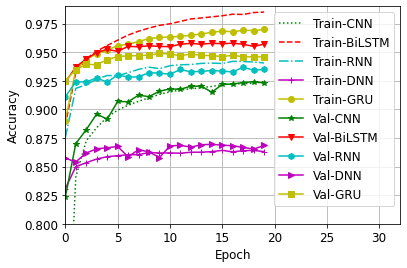

In [71]:
import matplotlib.pyplot as plt

plt.figure(1)
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(LSTMhistory.history['accuracy'], 'r--')
plt.plot(RNNhistory.history['accuracy'], 'c-.')
plt.plot(DNNhistory.history['accuracy'], 'm-+')
plt.plot(GRUhistory.history['accuracy'], 'y-o')

plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
plt.plot(LSTMhistory.history['val_accuracy'], 'r-v')
plt.plot(RNNhistory.history['val_accuracy'], 'c-h')
plt.plot(DNNhistory.history['val_accuracy'], 'm->')
plt.plot(GRUhistory.history['val_accuracy'], 'y-s')

#plt.xscale('log')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 0.99)
plt.xlim(0,32)
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-DNN', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-DNN', 'Val-GRU'], loc='upper right')


plt.gcf().savefig('accuracy.eps', format='eps', dpi=600)     # save the figure

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


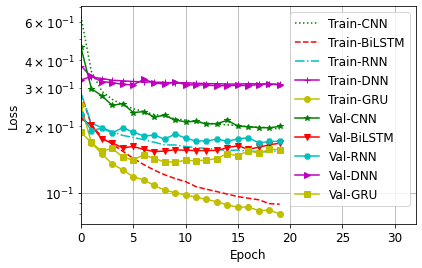

In [72]:
plt.figure(2)
# summarize for loss
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(LSTMhistory.history['loss'], 'r--')
plt.plot(RNNhistory.history['loss'], 'c-.')
plt.plot(DNNhistory.history['loss'], 'm-+')
plt.plot(GRUhistory.history['loss'], 'y-o')


plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.plot(LSTMhistory.history['val_loss'], 'r-v')
plt.plot(RNNhistory.history['val_loss'], 'c-H')
plt.plot(DNNhistory.history['val_loss'], 'm->')
plt.plot(GRUhistory.history['val_loss'], 'y-s')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Train-BiLSTM', 'Train-RNN', 'Train-DNN', 'Train-GRU','Val-CNN',\
            'Val-BiLSTM', 'Val-RNN', 'Val-DNN', 'Val-GRU'], loc='upper right')
plt.yscale('log')
#plt.xscale('log')
plt.grid('True')
plt.xlim(0,32)
plt.gcf().savefig('loss.eps', format='eps', dpi=600)     # save the figure

## 1.11 Statistics

In [73]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
y_predLSTM =(LSTMmodel.predict(x_test) > 0.5).astype("int32")
y_predRNN =(RNNmodel.predict(x_test) > 0.5).astype("int32")
y_predGRU =(GRUmodel.predict(x_test) > 0.5).astype("int32")
y_predDNN =(DNNmodel.predict(x_test) > 0.5).astype("int32")

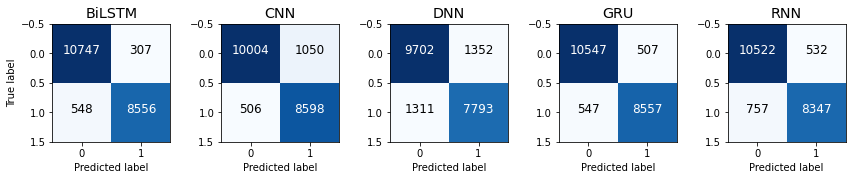

In [78]:
# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix
%matplotlib inline
import itertools

cm1 = confusion_matrix(y_true=y_test, y_pred=y_predLSTM)
cm2 = confusion_matrix(y_true=y_test, y_pred=y_predCNN)
cm3 = confusion_matrix(y_true=y_test, y_pred=y_predDNN)
cm4 = confusion_matrix(y_true=y_test, y_pred=y_predGRU)
cm5 = confusion_matrix(y_true=y_test, y_pred=y_predRNN)


fig, axes = plt.subplots(1, 5, figsize=(12, 4))
fig.tight_layout(pad=2.0)             #space between plots
#fig.set_size_inches(9,6)
plt.rcParams.update({'font.size': 12}) 
cmap=plt.cm.Blues

axes[0].imshow(cm1, interpolation='nearest', cmap=cmap)
axes[0].set_title('BiLSTM')
#axes[0].colorbar()
thresh = cm1.max() / 2.
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
  axes[0].text(j, i, cm1[i, j],
  horizontalalignment="center",
  color="white" if cm1[i, j] > thresh else "black")
  axes[0].set_ylabel('True label')
  axes[0].set_xlabel('Predicted label')

axes[1].imshow(cm2, interpolation='nearest', cmap=cmap)
axes[1].set_title('CNN')
thresh = cm2.max() / 2.
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
  axes[1].text(j, i, cm2[i, j],
  horizontalalignment="center",
  color="white" if cm2[i, j] > thresh else "black")
  #axes[1].set_ylabel('True label')
  axes[1].set_xlabel('Predicted label')

axes[2].imshow(cm3, interpolation='nearest', cmap=cmap)
axes[2].set_title('DNN')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm3.shape[0]), range(cm3.shape[1])):
  axes[2].text(j, i, cm3[i, j],
  horizontalalignment="center",
  color="white" if cm3[i, j] > thresh else "black")
  #axes[2].set_ylabel('True label')
  axes[2].set_xlabel('Predicted label')

axes[3].imshow(cm4, interpolation='nearest', cmap=cmap)
axes[3].set_title('GRU')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm4.shape[0]), range(cm4.shape[1])):
  axes[3].text(j, i, cm4[i, j],
  horizontalalignment="center",
  color="white" if cm4[i, j] > thresh else "black")
  #axes[3].set_ylabel('True label')
  axes[3].set_xlabel('Predicted label')


axes[4].imshow(cm5, interpolation='nearest', cmap=cmap)
axes[4].set_title('RNN')
thresh = cm3.max() / 2.
for i, j in itertools.product(range(cm5.shape[0]), range(cm5.shape[1])):
  axes[4].text(j, i, cm5[i, j],
  horizontalalignment="center",
  color="white" if cm5[i, j] > thresh else "black")
  #axes[4].set_ylabel('True label')
  axes[4].set_xlabel('Predicted label')

plt.gcf().savefig('fig.eps', format='eps', dpi=600)     # save the figure

In [77]:
plt.gcf().savefig('cmatrix.eps', format='eps', dpi=600)     # save the figure

<Figure size 432x288 with 0 Axes>

In [44]:
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_predLSTM)
recall_score(y_test, y_predLSTM)

0.945298769771529

## 1.12 Testing 

In [67]:
testename = prepare_encod_names({"cibely"})   # Now the names are encod as a vector of numbers with weight
resu=(LSTMmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

F
